# Multi-Echo fMRI Sequences

In this chapter, we give a high level overview of MRI pulse sequences with the goal of explaining what is involved in how different parameters interact with multi-echo fMRI acqusition.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# These functions are used to make the simplified pulse sequence visualizations
def plt_sinc(x_start, x_dur):
    """Plot a sinc function that start at time x_start and lasts for x_dur ms."""
    n_vals = 100
    sinc_vals = np.sinc(np.linspace(-4, 4, n_vals))
    sinc_timing = np.linspace(x_start, x_start+x_dur, n_vals)
    plt.plot(sinc_timing, sinc_vals, 'k', linewidth=0.75)

def plt_sin(x_center, x_dur, n_cycles, color):
    """
    Plot a sin wave
    
    Parameters
    ----------
    x_center: The center time for the sin wave in ms
    x_dur: The duration of the sin wave
    n_cycles: The number of cycles in the sin wave
    color: The color of the line for the sin wave
    """
    n_vals = 1000
    sin_vals = np.sin(n_cycles*2*np.pi*np.linspace(0,1,n_vals))/2
    sin_timing = np.linspace(x_center-x_dur/2, x_center+x_dur/2, n_vals)
    plt.plot(sin_timing, sin_vals, color, linewidth=0.75)

    
def create_simple_pulse_seq(tes, read_time=None, x_axis_duration=None, n_acq = 2, n_cycles=16, sinc_dur=2, title=None):
    """
    Create a simple pulse sequence figure with the goal of explaining multi-echo

    Parameters
    ----------
    tes (List): The echo times (TEs) in milliseconds
    read_time: The duration of the read time for each echo (i.e. how long the sinusoids will appear)
        Default is None. For >2 echos, this will calculate read times as
        0.95*(the difference between the first wo echoes)
        Will crash if this is None with only 1 echo
    x_axis_duration: The range of the x axis goes from x to this value.
        Default is None and will be long enough to show the full echo train
        Can be set so that several plots have the same x range and can be compared
    n_acq: The number of sinc pulses followed by sinusoids to include
        Default is 2
    n_cycles: Number of sinusoid cycles to show in each echo train
        Default is 16, which is less than most actual acquisitions,
        but more realistic values make it hard to see the sinusoids compressing with different read_times
    sinc_dur: The shape of the sinc for the excitation pulse is hard coded,
    but it can be made larger or smaller to support visualization
        Default is 2
    title: A text string title for the plot
    
    Returns
    -------
    read_time, x_axis_duration: Same has above, but will be want was calculated within the code
        Useful if running the longest duration pulse sequence first and then using the same
        x_axis_duration for all other plots
    """

    if len(tes) == 1:
        colorlist = ['g']
        #if x_axis_duration == None:
        #    x_axis_duration = n_acq*(tes[0] + read_time/2) + 7
    else:
        colorlist = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        if read_time == None:
            read_time = 0.95*(tes[1]-tes[0])
        if x_axis_duration == None:
            x_axis_duration = n_acq*(tes[-1] + read_time/2) + 7

    excite_start = 0
    for acq_iter in range(n_acq):
        plt_sinc(excite_start, sinc_dur)
        for echo_idx, echo_val in enumerate(tes):
            plt_sin(excite_start+echo_val, read_time, n_cycles, colorlist[echo_idx])
            plt.plot(excite_start+np.linspace(sinc_dur/2, echo_val, 20), np.tile(0.52+echo_idx*0.1, 20), 'k', linestyle='--')
            plt.text(excite_start+(echo_val - sinc_dur/2)/2, 0.53+0.1*echo_idx, f"TE {echo_idx+1}")
        excite_start = excite_start + echo_val + read_time/2 + 0.5
        if acq_iter == 0:
            plt.plot([0, excite_start], [1, 1], 'k', linestyle='-.')
            plt.text(excite_start*0.45, 1.01, "1 acquisition cycle")

    plt.xlim(0,x_axis_duration)
    plt.xlabel('Time (ms)')
    if title:
        plt.title(title)

    return read_time, x_axis_duration

## A simplified fMRI pulse sequence

NameError: name 'glue' is not defined

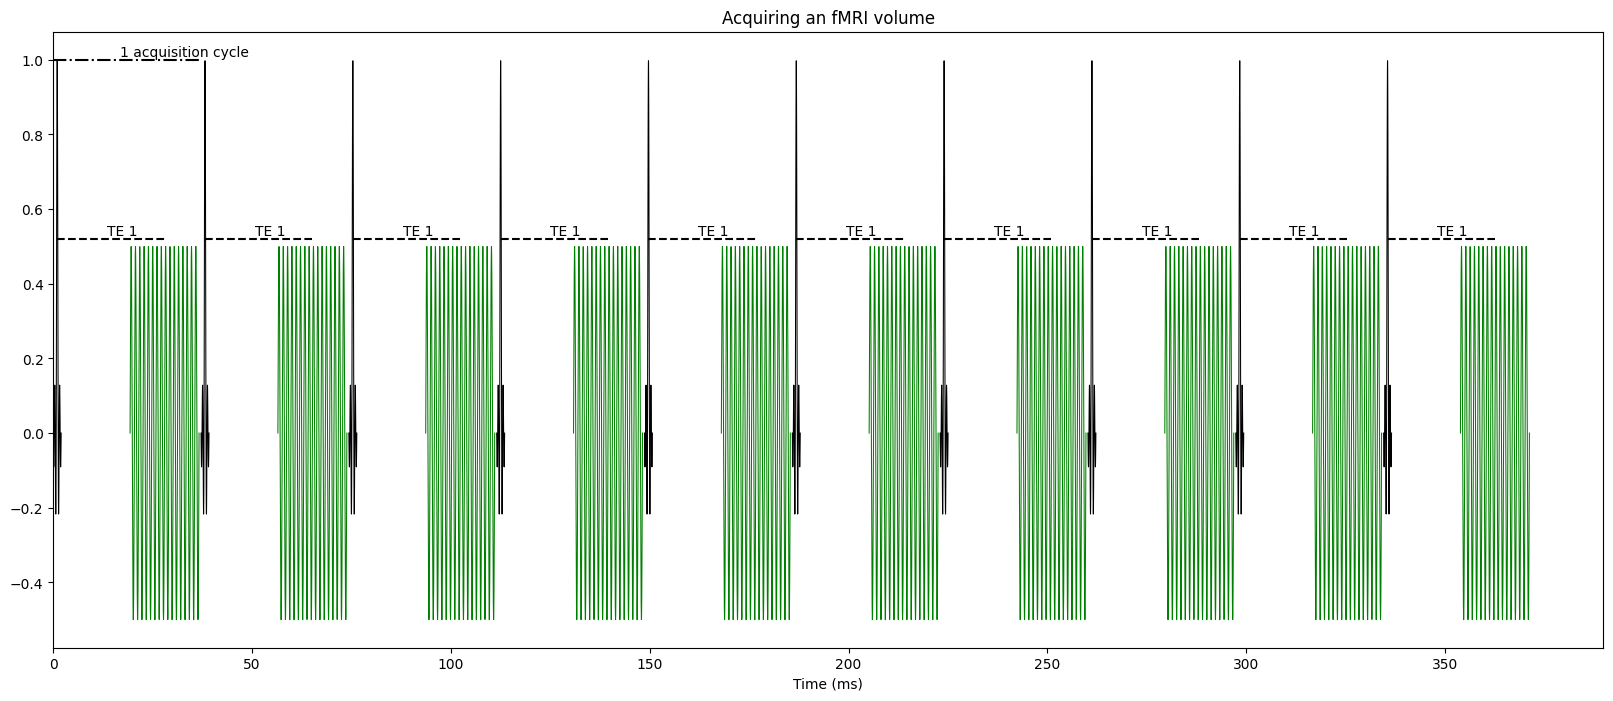

In [3]:
plt.figure(figsize=(20,8))

create_simple_pulse_seq([28], read_time=17.347, n_acq=10, title="Acquiring an fMRI volume")

glue("fig_sample_pulse_seq", fig, display=False)

```{glue:figure} fig_sample_pulse_seq
:name: fig_sample_pulse_seq
:align: center

A simplified fMRI pulse sequence
```

For the purposes of understanding multi-echo fMRI,
an fMRI pulse sequence has two main parts.
The excitation pulse (black) and the readout (green).
The excitation pulse sends out a radio frequence pulse that excites protons at a resonance frequency
(The "resonance" part of Magnetic Resonance Imaging).
The readout period (green) is when the magnetic oscillates
to acquire data across a portion of k-space.
In a typical fMRI study, each excitation pulse excites protons in
one slice or several slices of the brain,
and then the readout period collects data from those slice(s).
Multiple excitation pulses and readout windows are necessary to collect a full volume.
In this figure, there are 10 excitation pulses.
If 4 slices were collected with each excitation pulse,
(called simultaneous multislice, multiband, or hyperband imaging),
this figure represents acquiring 40 slices.
In this example, each excitation + readout cycle takes around 37ms,
and the time to aquire a 40 slice volume would be 370ms.

Note that there is a gap between the excitation pulse and the readout window.
This gap is called the echo time (TE).
That gap is not due to hardware constraints.
It is because the Blood Oxygen Level Dependent (BOLD) signal
that is central to most fMRI studies is largest with a specfic delay.
There is more information about the link between BOLD contrast
and TE in the following sections.
For example, for a 3T MRI, the BOLD contrast is largest at approximately 28ms.

Also note that the readout period is not instantaneous.
It takes time to have the magnetic gradients to move around in ways that collect the desired information across k-space.
The TE is the center of this readout period.
In this figure, the TE is 28ms, but the readout period is acquiring data from around 19-36ms.

## A multi-echo fMRI pulse sequence

In [ ]:
plt.figure(figsize=(20,16))

plt.subplot(3,1,2)
read_time, x_axis_duration = create_simple_pulse_seq([13, 31.26, 49.52], title="3 echoes. In-slice accelleration=2")

plt.subplot(3,1,1)
create_simple_pulse_seq([28], read_time=read_time, x_axis_duration=x_axis_duration, title="single echo. In-slice accelleration=2")

plt.subplot(3,1,3)
create_simple_pulse_seq([10.2, 22.27, 34.94], x_axis_duration=x_axis_duration, title="3 echoes. In-slice accelleration=3")

glue("fig_sample_multiecho_pulse_seq", fig, display=False)

```{glue:figure} fig_sample_multiecho_pulse_seq
:name: fig_sample_multiecho_pulse_seq
:align: center

A sample multi-echo fMRI pulse sequence
```